# Cost and Processing-Time Prediction for Parallel Matrix Operations

In [1]:
import math
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np

In [2]:
MatrixDimensions = namedtuple('MatrixDimensions', ['height', 'width'])

### Lambda Cost

In [49]:
# lambda cost
price_per_request = 0.0000002 # in $
price_per_GBs = 0.00001667 # in $

# Average Execution Times according to block size
intermediate_exec_time = { '1000': 2500, '2000':  14000, '3000': 42570, '4000': 56294}
collect_exec_time = { '1000': 3900,'2000': 13000, '3000': 22157, '4000': 15744}
accumulate_exec_time = {'1000': 2000,'2000': 6700, '3000': 10096, '4000': 4924}

In [33]:
(295800)/1000 * 1536 * (price_per_GBs/1024.0)

0.007376475

In [25]:
C_exec = (3258.0 * (1536.0/1024.0) + 45402.0) * 0.00001667
print C_exec
print 528 * 0.0000002
C_lambda = C_exec + 528 * 0.0000002
print C_lambda

0.83831763
0.0001056
0.83842323


In [48]:
def lambda_execution_cost(milliseconds, memory):
    price_per_GBs = 0.00001667 # in $
    ms_rounded_up = math.ceil(milliseconds/100.0) * 100.0
    return (ms_rounded_up)/1000 * memory * (price_per_GBs/1024.0)

In [47]:
def execution_time(splits, units_per_split, blocksize):
    units = splits * units_per_split
    intermediates = 7
    collectors = 1
    
    intermediate_time = units * intermediates * intermediate_exec_time[str(blocksize)]
    collector_time = units * collectors * collect_exec_time[str(blocksize)]
    accumulator_time = splits * ACCUMULATORS_PER_SPLIT * accumulate_exec_time[str(blocksize)]
    
    print("Lambdas: {}".format(units*(intermediates+collectors) + splits))

    return  intermediate_time + collector_time + accumulator_time

In [51]:
def lambda_request_cost(splits, units_per_split):
    units = splits*units_per_split
    requests = 8 * units + 1 * splits
    return 0.0000002 * requests

In [243]:
lambda_execution_cost(1872000, 1024)

0.031206240000000003

### StepFunction Cost

In [45]:
price_per_transition = 0.000025 # in $

TRANSITIONS_PER_UNIT_OLD = 2 + 14 + 1
# 2 in/out of unit-pass, 7 intermediates, 1 collector
TRANSITIONS_PER_UNIT = 2 + 7 + 1
ACCUMULATORS_PER_SPLIT = 1

In [46]:
def transitions_for_split_with(units):
    start = 1 # transition to surrounding parallel state
    unit_transitions = units * TRANSITIONS_PER_UNIT
    accumulators = 1
    accumulate_transitions = ACCUMULATORS_PER_SPLIT * 2 # in and out of accum.
    return start + unit_transitions + accumulate_transitions

In [29]:
4*transitions_for_split_with(2)

92

In [21]:
units = 2
transitions_for_split_with(units)

23

### S3 cost

In [39]:
# standard infrequent access
price_per_put_request =  0.01 /  1000.0 # in $
price_per_get_request = 0.001 / 10000.0 # in $

In [56]:
# standard infrequent access
price_per_put_request =  0.0054 /  1000.0 # in $
price_per_get_request = 0.0043 / 10000.0 # in $

In [40]:
# multipart uploads
kB = 1024
MB = kB * kB
multipart_threshold = 8 * MB
multipart_chunksize = 8 * MB

from collections import OrderedDict
blocksizes_in_MB = OrderedDict({ 1000: 7.6, 2000: 30.5 , 3000: 72.0, 4000: 128.0, 5000: 200.0, 6000: 288.0, 7000: 392.0, 8000: 512.0 })

In [41]:
def estimate_puts(splits, units_per_split):
    uploads_per_intermediate = 1
    uploads_per_collector = 4
    uploads_per_accumulator = 4
    
    intermediate_uploads = uploads_per_intermediate * 7 * splits * units_per_split
    collector_uploads = uploads_per_collector * splits * units_per_split
    accumulators_uploads = uploads_per_collector * splits
    
    return intermediate_uploads + collector_uploads + accumulators_uploads
    

def estimate_gets(splits, units_per_split):
    downloads_per_intermediate = (4 * 3 + 3 * 4) / 7 # = 3,43 downloads on average
    downloads_per_collector = 12
    downloads_per_accumulator = 4 * units_per_split
    
    intermediate_downloads = downloads_per_intermediate * units_per_split * splits
    collector_downloads = downloads_per_collector * units_per_split * splits
    accumulators_downloads = downloads_per_accumulator * splits

    return intermediate_downloads + collector_downloads + accumulators_downloads

In [42]:
def s3_request_cost(puts, gets, data_transfered_in_MB):
    data_transfer_cost = data_transfered_in_MB * 0.01/1024
    put_cost = puts * price_per_put_request
    get_cost = gets * price_per_get_request
    return data_transfer_cost + put_cost + get_cost

In [33]:
print estimate_puts(4, 2)
print estimate_gets(4, 2)

104
152


### Total Cost

In [205]:
m = 16000
p = 16000
splitsize = 2000
splits = m/splitsize * p/splitsize
print splits

64


In [43]:
def calculate_cost(matA, matB, blocksize):
    print matA
    print matB
    print blocksize
    splitsize = blocksize * 2
    
    # Values
    m = matA.height
    n = matA.width
    p = matB.width
    
    units_per_split = n / splitsize
    splits = m/splitsize * p/splitsize
    
    print 'Splits: {}, with {} units per split'.format(splits, units_per_split)
    print 'Units total:' , units_per_split * splits
    
    print '\nCost division'
    
    lmbd = calculate_lambda_cost(splits, units_per_split, blocksize)
    print 'Lambda cost: $', lmbd
    sfn = calculate_stepfunction_cost(splits, units_per_split)
    print 'StepFunction cost: $', sfn
    s3 = calculate_s3_cost(splits, units_per_split)
    print 'S3 cost: $', s3
            
    print '------\nTotal: $', lmbd + s3 + sfn
    print '\n\n\n'
    if (lmbd + s3 + sfn) == 0.0:
        return None
    else:
        return lmbd + s3 + sfn

def calculate_lambda_cost(splits, units_per_split, blocksize):
    exec_time = execution_time(splits, units_per_split, blocksize)
    exec_cost = lambda_execution_cost(milliseconds=exec_time, memory=1024)
    request_cost = lambda_request_cost(splits, units_per_split)
    return exec_cost + request_cost

def calculate_stepfunction_cost(splits, units_per_split):
    transitions = splits * transitions_for_split_with(units_per_split) 
    return transitions * price_per_transition

def calculate_s3_cost(splits, units_per_split):
    puts=estimate_puts(splits, units_per_split)
    gets=estimate_gets(splits, units_per_split)
    return s3_request_cost(puts, gets, data_transfered_in_MB=0)

In [395]:
res1 = calculate_cost(MatrixDimensions(height=2000, width=2000), MatrixDimensions(height=2000, width=2000), blocksize=1000)

MatrixDimensions(height=2000, width=2000)
MatrixDimensions(height=2000, width=2000)
1000
Splits: 1, with 1 units per split
Units total: 1

Cost division
Lambdas: 9
Lambda cost: $ 0.000391878
StepFunction cost: $ 0.000325
S3 cost: $ 0.0001519
------
Total: $ 0.000868778






In [ ]:
calculate_cost(MatrixDimensions(height=4000, width=4000), MatrixDimensions(height=4000, width=4000), blocksize=1000)
calculate_cost(MatrixDimensions(height=4000, width=4000), MatrixDimensions(height=4000, width=4000), blocksize=2000)
calculate_cost(MatrixDimensions(height=4000, width=4000), MatrixDimensions(height=4000, width=4000), blocksize=4000)

In [26]:
tester = {'a':{}}
tester['a']['hello'] = 3
tester

{'a': {'hello': 3}}

In [58]:
costs = { 1000: {}, 2000: {}, 4000: {} }
for blocksize in [1000, 2000, 4000]:
    for dim in [2000, 4000, 8000]:
        costs[blocksize][2*(dim/1000)**2] = calculate_cost(MatrixDimensions(height=dim, width=dim), MatrixDimensions(height=dim, width=dim), blocksize)

MatrixDimensions(height=2000, width=2000)
MatrixDimensions(height=2000, width=2000)
1000
Splits: 1, with 1 units per split
Units total: 1

Cost division
Lambdas: 9
Lambda cost: $ 0.000391878
StepFunction cost: $ 0.000325
S3 cost: $ 8.917e-05
------
Total: $ 0.000806048




MatrixDimensions(height=4000, width=4000)
MatrixDimensions(height=4000, width=4000)
1000
Splits: 4, with 2 units per split
Units total: 8

Cost division
Lambdas: 68
Lambda cost: $ 0.003000864
StepFunction cost: $ 0.0023
S3 cost: $ 0.00062696
------
Total: $ 0.005927824




MatrixDimensions(height=8000, width=8000)
MatrixDimensions(height=8000, width=8000)
1000
Splits: 16, with 4 units per split
Units total: 64

Cost division
Lambdas: 528
Lambda cost: $ 0.023470272
StepFunction cost: $ 0.0172
S3 cost: $ 0.00467008
------
Total: $ 0.045340352




MatrixDimensions(height=2000, width=2000)
MatrixDimensions(height=2000, width=2000)
2000
Splits: 0, with 0 units per split
Units total: 0

Cost division
Lambdas: 0
Lambda cost

In [74]:
costs[4000][512] = 0.058349794

In [53]:
costs

{1000: {8: 0.000868778, 32: 0.006356064, 128: 0.048471872},
 2000: {8: None, 32: 0.0024407590000000007, 128: 0.018618516},
 4000: {8: None, 32: None, 128: 0.007393416}}

In [59]:
costs

{1000: {8: 0.0008060480000000001, 32: 0.005927824, 128: 0.045340352},
 2000: {8: None, 32: 0.0023780290000000007, 128: 0.018190276000000002},
 4000: {8: None, 32: None, 128: 0.007330686}}

In [19]:
import matplotlib

/Users/Johannes/Library/Python/2.7/lib/python/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


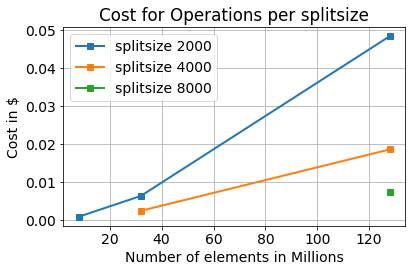

In [20]:
%matplotlib inline

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'figure.autolayout': True})

plt.plot(costs[1000].keys(), costs[1000].values(), linestyle='-', linewidth=2, marker='s')
plt.plot(costs[2000].keys(), costs[2000].values(), linestyle='-', linewidth=2, marker='s')
plt.plot(costs[4000].keys(), costs[4000].values(), linestyle='-', linewidth=2, marker='s')

plt.grid()
plt.xlabel('Number of elements in Millions')
plt.ylabel('Cost in $')
plt.title('Cost for Operations per splitsize')
plt.legend(('splitsize 2000', 'splitsize 4000', 'splitsize 8000'))

plt.savefig('/Users/Johannes/Desktop/cost.png', dpi=600)

In [20]:
calculate_cost(MatrixDimensions(height=8000, width=8000), MatrixDimensions(height=8000, width=8000), blocksize=1000)
calculate_cost(MatrixDimensions(height=8000, width=8000), MatrixDimensions(height=8000, width=8000), blocksize=2000)
calculate_cost(MatrixDimensions(height=8000, width=8000), MatrixDimensions(height=8000, width=8000), blocksize=4000)

MatrixDimensions(height=8000, width=8000)
MatrixDimensions(height=8000, width=8000)
1000
Splits: 16, with 4 units per split
Units total: 64

Cost division
Lambdas: 528
Lambda cost: $ 0.023470272
StepFunction cost: $ 0.0172
S3 cost: $ 0.0078016
------
Total: $ 0.048471872




MatrixDimensions(height=8000, width=8000)
MatrixDimensions(height=8000, width=8000)
2000
Splits: 4, with 2 units per split
Units total: 8

Cost division
Lambdas: 68
Lambda cost: $ 0.015263316
StepFunction cost: $ 0.0023
S3 cost: $ 0.0010552
------
Total: $ 0.018618516




MatrixDimensions(height=8000, width=8000)
MatrixDimensions(height=8000, width=8000)
4000
Splits: 1, with 1 units per split
Units total: 1

Cost division
Lambdas: 9
Lambda cost: $ 0.006916516
StepFunction cost: $ 0.000325
S3 cost: $ 0.0001519
------
Total: $ 0.007393416






0.007393416

In [27]:
calculate_cost(MatrixDimensions(height=8000, width=16000), MatrixDimensions(height=16000, width=8000), blocksize=2000)

MatrixDimensions(height=8000, width=16000)
MatrixDimensions(height=16000, width=8000)
2000
Splits: 4, with 4 units per split
Units total: 16

Cost division
Lambdas: 132
Lambda cost: $ 0.030079076
StepFunction cost: $ 0.0043
S3 cost: $ 0.0019504
------
Total: $ 0.036329476






0.036329476

In [60]:
calculate_cost(MatrixDimensions(height=16000, width=16000), MatrixDimensions(height=16000, width=16000), blocksize=4000)

MatrixDimensions(height=16000, width=16000)
MatrixDimensions(height=16000, width=16000)
4000
Splits: 4, with 2 units per split
Units total: 8

Cost division
Lambdas: 68
Lambda cost: $ 0.054994594
StepFunction cost: $ 0.0023
S3 cost: $ 0.00062696
------
Total: $ 0.057921554






0.057921554

In [36]:
calculate_cost(MatrixDimensions(height=8000, width=8000), MatrixDimensions(height=8000, width=8000), blocksize=4000)

NameError: name 'calculate_cost' is not defined

In [274]:
calculate_cost(MatrixDimensions(height=6000, width=6000), MatrixDimensions(height=6000, width=6000), blocksize=3000)

Splits: 1, with 1 units per split
Units total: 1

Cost division
Lambdas: 9
Lambda cost: $ 0.005507901
StepFunction cost: $ 0.000325
S3 cost: $ 0.0001519
------
Total: $ 0.005984801


In [275]:
calculate_cost(MatrixDimensions(height=9000, width=9000), MatrixDimensions(height=9000, width=9000), blocksize=3000)

Splits: 1, with 1 units per split
Units total: 1

Cost division
Lambdas: 9
Lambda cost: $ 0.005507901
StepFunction cost: $ 0.000325
S3 cost: $ 0.0001519
------
Total: $ 0.005984801


In [ ]:
def plot_total_time_vs_total_cost_prediction():
    # as a function of blocksize for a fixed Matrix Multiplication (e.g. 8k*8k)
    

In [378]:
blocksizes = np.arange(1000,5000,1000)
blocksizes

array([1000, 2000, 3000, 4000])

In [396]:
operation_sizes = [2*x**2 for x in range(2,9)]
operation_sizes

[8, 18, 32, 50, 72, 98, 128]

In [381]:
[[0,0.000868778, 18, 0.006356064, 50, 72, 98, 0.048471872], #1000
 [0,0, 0, 0.002440759, 50, 72, 98, 0.018618516], #2000
 [0,0, 0, 0, 0, 0, 0, 0.013005966], #3000 calculated
 [0,0, 0, 0, 0, 0, 0, 0.007393416]] #4000

[[0, 0, 18, 32, 50, 72, 98, 0.048471872],
 [0, 0, 18, 32, 50, 72, 98, 0.018618516],
 [0, 0, 18, 32, 50, 72, 98, 128],
 [0, 0, 18, 32, 50, 72, 98, 0.007393416]]

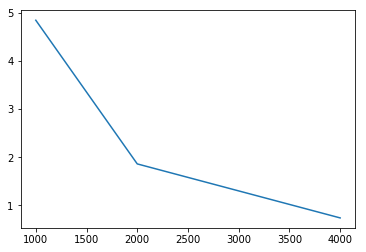

In [403]:
plt.plot([1000,2000,4000],[04.8471872,001.8618516,000.7393416])
plt.show()

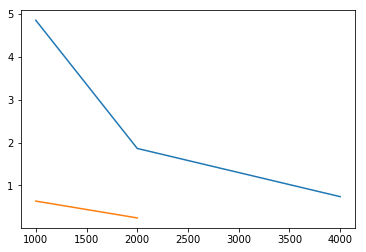

In [408]:
fig, ax = plt.subplots()

p1 = plt.plot([2000,4000,8000],[04.8471872,001.8618516,000.7393416])
p2 = plt.plot([2000,4000],[000.6356064, 000.24407590000000007])
p3 = plt.plot([2000],[])

plt.show()


In [405]:
print [res1, res2, res3]

[0.006356064, 0.0024407590000000007, 0.0]
